---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: true
execute:
    warning: false
---


{{< include overview.qmd >}} 


# Code 

Code for this webpage can be found [here.](https://github.com/dsan-5000/project-dcorc7/blob/main/technical-details/unsupervised-learning/main.ipynb)

## Importing Python Libraries

The first step to working with unsupervised learning techniques is to import the appropriate Python libaries. The Python packages that I imported, as well as the reasons for importing them, are as follows:

- **pandas:** To work with and store retrieved data into pandas dataframes

- **numpy:** To perform statistical and mathematic operations

- **sklearn:** To perform unsupervised learning techniques (dimensionality reduction and clustering)

- **matplotlib:** To create professional-looking statiscal plots on the cleaned movie data

- **seaborn:** To accompany the plots made using the matplotlib library

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import numpy as np

## Load the Dataset

In [2]:
movies_df = pd.read_csv("../../data/processed-data/movies_cleaned.csv")

## Dimensionality Reduction

### Principal Component Analysis (PCA)

To conduct PCA, I first filtered the dataset to only include numerical features, as dimensionality reduction does not take into account categorical values. Upon filtering, the data was normalized using StandardScaler and PCA performed using the sklearn Python library. 

In [3]:
# Create new dataframe with just numerical data, no categorical or text data
columns_to_keep = ["Year", "Runtime", "Metascore_Rating", "IMDB_Rating", "Rotten_Tomatoes_Rating",
                   "TMDB_Rating", "Average_Rating", "Budget_Normalized",
                   "Revenue_Normalized", "Return_On_Investment", "Popularity", "Age_Rating"]
numerical_movies_df = movies_df[columns_to_keep]


# Encode Age_Rating labels
label_encoder = LabelEncoder()
numerical_movies_df["Age_Rating_Encoded"] = label_encoder.fit_transform(movies_df["Age_Rating"])

# Drop catoagized Age_Rating column
numerical_movies_df = numerical_movies_df.drop(["Age_Rating"], axis = 1)

# Standardize data
scaler = StandardScaler()
numerical_movies_scaled = scaler.fit_transform(numerical_movies_df)


# Perform PCA
pca = PCA(n_components = len(numerical_movies_df.columns))
movies_pca = pca.fit_transform(numerical_movies_scaled)

C:\Users\DCorc\AppData\Local\Temp\ipykernel_16820\3933717922.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_movies_df["Age_Rating_Encoded"] = label_encoder.fit_transform(movies_df["Age_Rating"])


To determine the optimal number of features that should be inputted into the PCA code, I used np.cumsum on the previously performed pca variable to find the minimum number of components that explain variance in the dataset. Plots depicting explained variance per component and cumulative explained variance are shown below. The minimum number of components to explain 90% of the variance within the data features using this method is 6. Another method of deciding this value is the elbow method. This method uses the explained variance per component plot to identify the number of components in which there is an "elbow," or drastic change in variance slope. For this project, I used the elbow method, as the "elbow" was very clear to see. As a result, the number of principal components in the PCA plot is 3, reducing the number of dimensions by 10. Using the cumulative explained variance plot, the percentage of explained varaince explaine by 3 principal compoennts is around 70%.

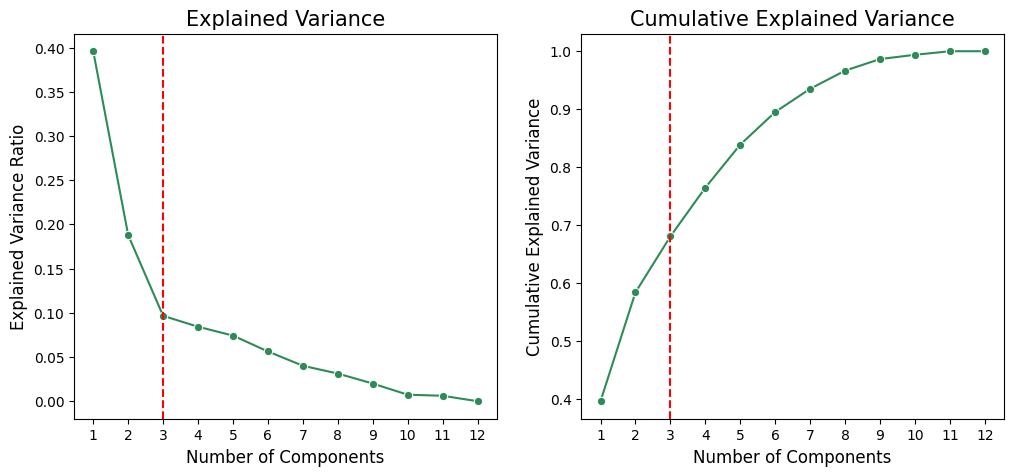

Optimal Components: 3
Cumulative Variance Explained: 0.6802996199586003


In [4]:
# Calculate the explained variance per component and cumulative exapline variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Calculate optimal number  optimal components using 90% method
optimal_components = 0
cum_variance_target = 0.9
for component in range(len(cumulative_variance) + 1):
    if cumulative_variance[component] >= cum_variance_target:
        optimal_components = (component + 1)
        break

# Optimal number of components using elbow method
optimal_components = 3

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

sns.lineplot(x = range(1, len(explained_variance) + 1), 
             y = explained_variance,
             marker = "o",
             color = "seagreen",
             ax = axes[0])
axes[0].set_title("Explained Variance", fontsize = 15)
axes[0].set_xlabel("Number of Components", fontsize = 12)
axes[0].set_ylabel("Explained Variance Ratio", fontsize = 12)
axes[0].set_xticks(range(1, len(cumulative_variance) + 1))
axes[0].axvline(x = optimal_components, color = "red", linestyle = "--", label = f"Optimal Components = {optimal_components}")


# Plot cumulative variance
sns.lineplot(x = range(1, len(cumulative_variance) + 1),
             y = cumulative_variance,
             marker = "o",
             color = "seagreen",
             ax = axes[1])
axes[1].set_title("Cumulative Explained Variance", fontsize = 15)
axes[1].set_xlabel("Number of Components", fontsize = 12)
axes[1].set_ylabel("Cumulative Explained Variance", fontsize = 12)
axes[1].set_xticks(range(1, len(cumulative_variance) + 1))
axes[1].axvline(x = optimal_components, color = "red", linestyle = "--", label = f"Optimal Components = {optimal_components}")
plt.show()

print(f"Optimal Components: {optimal_components}")
print(f"Cumulative Variance Explained: {cumulative_variance[optimal_components- 1]}")


Now that the optimal number of components has been determined, the data can be refit with PCA using the optimal number of components variable. After running the PCA method, the data was visualized in a scatterplot with all combinatoins of principal components on the axes. 

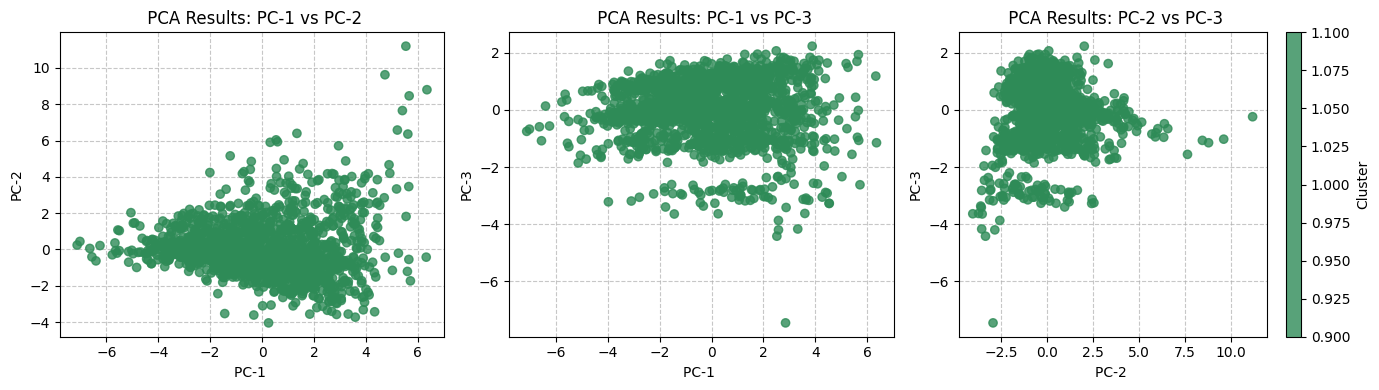

In [5]:
# Perform PCA with optimal components
pca = PCA(n_components = optimal_components)
movies_pca = pca.fit_transform(numerical_movies_scaled)


# Function used to plot the results of PCA
def plot_2D(reduced_data1, plot1, method1, reduced_data2, plot2, method2, color_vector):

    clusters = len(np.unique(color_vector))

    # Determine cluster colors based on cluster count
    if clusters == 1:
        custom_colors = ["seagreen"]
    elif clusters == 2:
        custom_colors = ["seagreen", "steelblue"]
    elif clusters == 3:
        custom_colors = ["seagreen", "steelblue", "gray"]
    elif clusters == 4:
        custom_colors = ["seagreen", "steelblue", "gray", "crimson"]
    elif clusters == 5:
        custom_colors = ["seagreen", "steelblue", "gray", "crimson", "coral"]
    else:
        custom_colors = ["seagreen", "steelblue", "gray", "crimson", "coral", "gold"]
        
    cmap = ListedColormap(custom_colors)

    # Plot only one plot if only one dataset is provided
    if reduced_data2 is None:
        

        if plot1 == "PCA":
            fig, axes = plt.subplots(1, 3, figsize = (14, 4))
            scatter1 = axes[0].scatter(reduced_data1[:, 0], reduced_data1[:, 1], c = color_vector, alpha = 0.8, cmap = cmap, zorder = 2)
            axes[0].set(xlabel = "PC-1 ", ylabel = "PC-2", title = f"{method1} PCA Results: PC-1 vs PC-2")
            axes[0].grid(True, linestyle = "--", alpha = 0.7, zorder = 1)

            scatter2 = axes[1].scatter(reduced_data1[:, 0], reduced_data1[:, 2], c = color_vector, alpha = 0.8, cmap = cmap, zorder = 2)
            axes[1].set(xlabel = "PC-1 ", ylabel = "PC-3", title = f"{method1} PCA Results: PC-1 vs PC-3")
            axes[1].grid(True, linestyle = "--", alpha = 0.7, zorder = 1)

            scatter3 = axes[2].scatter(reduced_data1[:, 1], reduced_data1[:, 2], c = color_vector, alpha = 0.8, cmap = cmap, zorder = 2)
            axes[2].set(xlabel = "PC-2 ", ylabel = "PC-3", title = f"{method1} PCA Results: PC-2 vs PC-3")
            axes[2].grid(True, linestyle = "--", alpha = 0.7, zorder = 1)

            plt.colorbar(scatter3, label = "Cluster")
        elif plot1 == "TSNE":
            plt.figure(figsize = (8, 6))
            scatter1 = plt.scatter(reduced_data1[:, 0], reduced_data1[:, 1], c = color_vector, alpha = 0.8, cmap = cmap, zorder = 2)
            plt.grid(True, linestyle = "--", alpha = 0.7, zorder = 1)
            plt.title(f"{method1} t-SNE Results")
            plt.xlabel("t-SNE-1")
            plt.ylabel("t-SNE-2")
            plt.colorbar(scatter1, label = "Cluster")
        else:
            print(f"Not a plotting option")

        plt.tight_layout()
        plt.show()

    # Plot both PCA and t-SNE plots in one figure if a second dataset is provided
    else:       
        # Plot 1 
        fig, axes = plt.subplots(1, 3, figsize = (14, 4))

        scatter1 = axes[0].scatter(reduced_data1[:, 0], reduced_data1[:, 1], c = color_vector, alpha = 0.8, cmap = cmap, zorder = 2)
        axes[0].set(xlabel = "PC-1 ", ylabel = "PC-2", title = f"{method1} PCA Results: PC-1 vs PC-2")
        axes[0].grid(True, linestyle = "--", alpha = 0.7, zorder = 1)

        scatter2 = axes[1].scatter(reduced_data1[:, 0], reduced_data1[:, 2], c = color_vector, alpha = 0.8, cmap = cmap, zorder = 2)
        axes[1].set(xlabel = "PC-1 ", ylabel = "PC-3", title = f"{method1} PCA Results: PC-1 vs PC-3")
        axes[1].grid(True, linestyle = "--", alpha = 0.7, zorder = 1)

        scatter3 = axes[2].scatter(reduced_data1[:, 1], reduced_data1[:, 2], c = color_vector, alpha = 0.8, cmap = cmap, zorder = 2)
        axes[2].set(xlabel = "PC-2 ", ylabel = "PC-3", title = f"{method1} PCA Results: PC-2 vs PC-3")
        axes[2].grid(True, linestyle = "--", alpha = 0.7, zorder = 1)

        plt.colorbar(scatter3, label = "Cluster")
        plt.tight_layout()
        plt.show()

        
        # Plot 2
        plt.figure(figsize = (5, 4))
        scatter4 = plt.scatter(reduced_data2[:, 0], reduced_data2[:, 1], c = color_vector, alpha = 0.8, cmap = cmap, zorder = 2)
        plt.grid(True, linestyle = "--", alpha = 0.7, zorder = 1)
        plt.title(f"{method1} t-SNE Results")
        plt.xlabel("t-SNE-1")
        plt.ylabel("t-SNE-2")

        plt.colorbar(scatter4, label = "Cluster")
        plt.tight_layout()
        plt.show()


# Visualize the PCA results
color_vector = [1] * len(numerical_movies_df)
plot_2D(reduced_data1 = movies_pca, plot1 = "PCA", method1 = "", 
        reduced_data2 = None, plot2 = None, method2 = None, 
        color_vector = color_vector)

Looking at the constructed PCA plots for each combination of principal components, no extremely distinct clusters have been generated. Instead, each plot looks semi-triangular, with most data points residing in the center and three branches spewing outwards from it. Below is the feature importance visualized for each principal component. PC-1 is dominated by movie rating features, indicating that it captures the overall quality of the movies across the 5 rating systems. PC-2 is strongly influenced by financial metrics (budget and revenue) and the popularity of movies. This component captures the scale and reach of movies, where high-budget, high-revenue, and popular movies score higher. Additionally, the Year feature suggests that more recent movies might align with higher values in PC-2. PC-3 is signficantly affected by a movie's Age Rating, indicating that movies futher along the PC-4 axis will be aimed at more mature audiences.

In [6]:
# Get PCA components
pca_loadings = pca.components_

# Create a df with features as rows and principal components as columns
pca_importance = pd.DataFrame(pca_loadings, 
                              index = [f"PC-{i + 1}" for i in range(pca_loadings.shape[0])], 
                              columns = numerical_movies_df.columns)

# Print top features for each component
for i, component in enumerate(pca_importance.index):
    print(f"\nTop Features for {component}:")
    print(pca_importance.loc[component].abs().sort_values(ascending = False).head())


Top Features for PC-1:
Average_Rating            0.444378
IMDB_Rating               0.422117
Rotten_Tomatoes_Rating    0.414888
Metascore_Rating          0.411535
TMDB_Rating               0.405108
Name: PC-1, dtype: float64

Top Features for PC-2:
Budget_Normalized     0.570588
Revenue_Normalized    0.517963
Year                  0.403103
Popularity            0.402832
Runtime               0.160723
Name: PC-2, dtype: float64

Top Features for PC-3:
Age_Rating_Encoded      0.863592
Year                    0.325518
Runtime                 0.226347
Revenue_Normalized      0.194023
Return_On_Investment    0.156076
Name: PC-3, dtype: float64


### t-distributed Stochastic Neighbor Embedding (t-SNE)



t-SNE was then performed on the same filtered dataset used for PCA. Using the same filtered numerical dataset, the t-SNE technqiue was run using the sklearn Python library. 

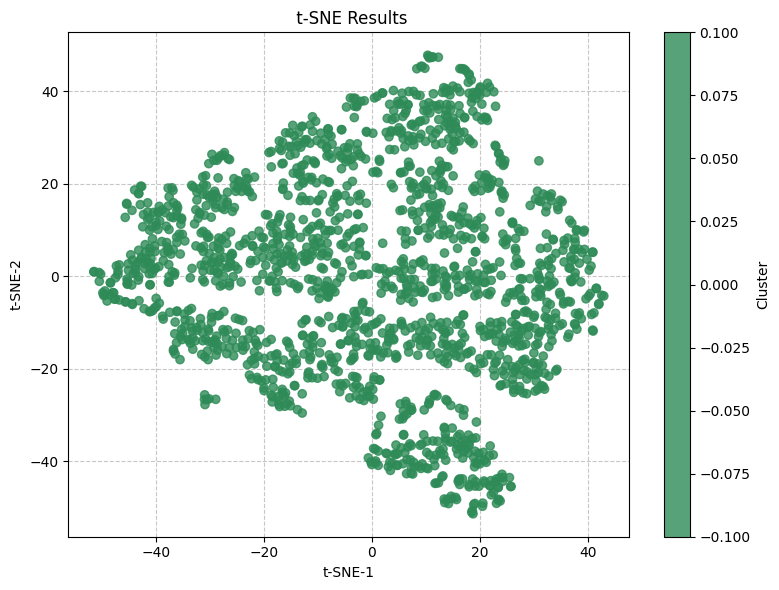

In [7]:
# Perform T-SNE
tsne = TSNE(n_components = 2)
movies_tsne = tsne.fit_transform(numerical_movies_scaled)

# Visualize the results
color_vector = [0] * len(numerical_movies_df)
plot_2D(reduced_data1 = movies_tsne, plot1 = "TSNE", method1 = "", 
        reduced_data2 = None, plot2 = None, method2 = None, 
        color_vector = color_vector)

The result of the t-SNE method is similar to the PCA plot, as the data is mostly contained within one grouping. However, there are places like in the bottom right, where separated groupings seem to exist. Now that both dimensionality reduction techniques were performed, the data can now attempt to be grouped using various clustering algorithms.

## Clustering



### K-Means

K-Means clustering requires the input of a cluster count, or k, before any computing can be done. Instead of individually inputting different k values into the code, the number of optimal clusters can be determined in one of two ways: the elbow method or silhouette score method. The elbow method involves calculating an intertia value, which is sum of squared distances between each data point and the centroid of its assigned cluster. This measures how well data points fit within their assigned clusters. The second method uses a silhouette score, which measures the quality of a clustering solution by average distance from a point to all other points in its own cluster. For this project, the silhouette score was used, as the elbow method can be subjective.

The plots below display the inertia and silhouette scores for each clustering solution. Using the silhouette score method, the optimal number of clusters using K-Means is 3. As a result, the data will be split into 3 groupings using K-Means. 

Optimal k: 3
 Optimal Score: 0.26871740911290354


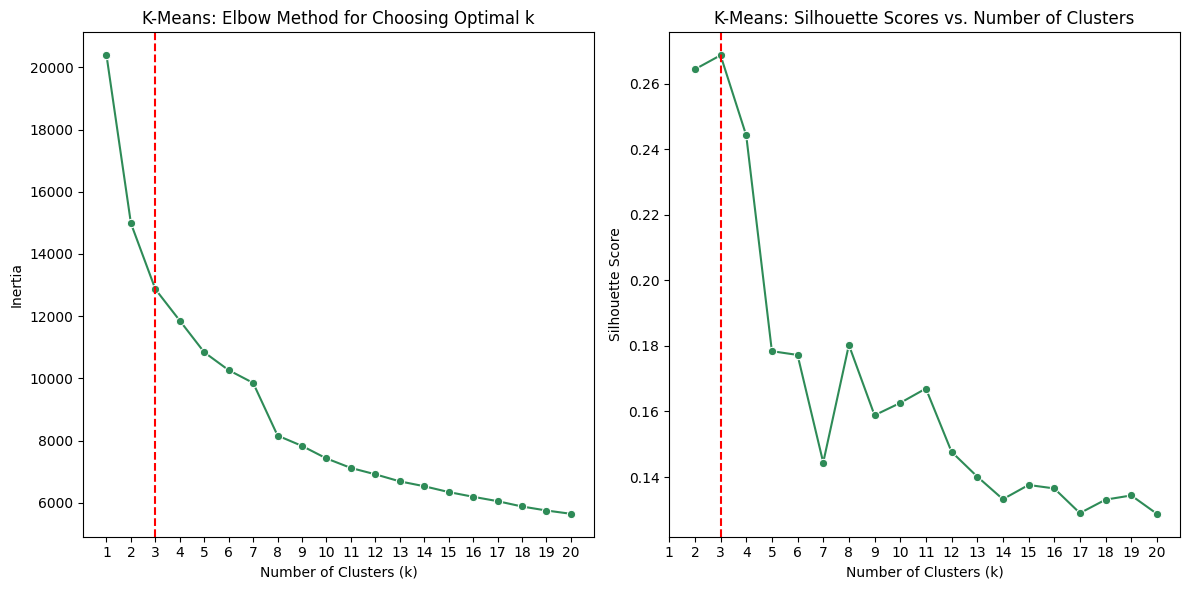

In [8]:
# K-Means Clustering Method

# Choose the number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
optimal_k = 0
optimal_score = 0
optimal_labels = None

# Create a varaible for the maximum amount of clusters the code will go through
k_testing_max = 21


# Calcualte scores for each clustering solution and save highest score, k, and labels
for k in range(1, k_testing_max):
    kmeans = KMeans(n_clusters = k, random_state = 7)
    labels = kmeans.fit_predict(numerical_movies_scaled)
    inertia.append(kmeans.inertia_)

    if len(set(labels)) > 1:
        score = silhouette_score(numerical_movies_scaled, labels)
        silhouette_scores.append(score)
        if score > optimal_score:
            optimal_score = score
            optimal_k = k
            optimal_labels = labels

print(f"Optimal k: {optimal_k}\n",
      f"Optimal Score: {optimal_score}")

# Insert cluster values for each movie inot the df
movies_df["KMeans_Cluster"] = optimal_labels


# Create a figure with 1 row and 2 columns of subplots so that graphs can be side-by-side
fig, axes = plt.subplots(1, 2, figsize = (12, 6))


# Visualize Elbow Method
sns.lineplot(x = range(1, k_testing_max), y = inertia, marker = "o", color = "seagreen", ax = axes[0])
axes[0].set_title("K-Means: Elbow Method for Choosing Optimal k")
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Inertia")
axes[0].set_xticks(range(1, k_testing_max))
axes[0].axvline(x = optimal_k, color = "red", linestyle = "--", label = f"Optimal k = {optimal_k}")

# Visualize Silhouette Scores
sns.lineplot(x = range(2, k_testing_max), y = silhouette_scores, marker = "o", color = "seagreen", ax = axes[1])
axes[1].set_title("K-Means: Silhouette Scores vs. Number of Clusters")
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_xticks(range(1, k_testing_max))
axes[1].axvline(x = optimal_k, color = "red", linestyle = "--", label = f"Optimal k = {optimal_k}")


plt.tight_layout()
plt.show()

To visualize the result of K-Means, PCA and t-SNE plots were regenerated, but with the newly calculated clusters. To recap, below is a summary of what each principal component represents.

- **PC-1:** Differentiates movies based on ratings across platforms. Movies with high ratings cluster together (Quality)
  
- **PC-2:** Captures how movies perform financially and in terms of an audience's reaction (Financial Success & Popularity)
  
- **PC-3:** Separates movies based on age rating (Audience Maturity)

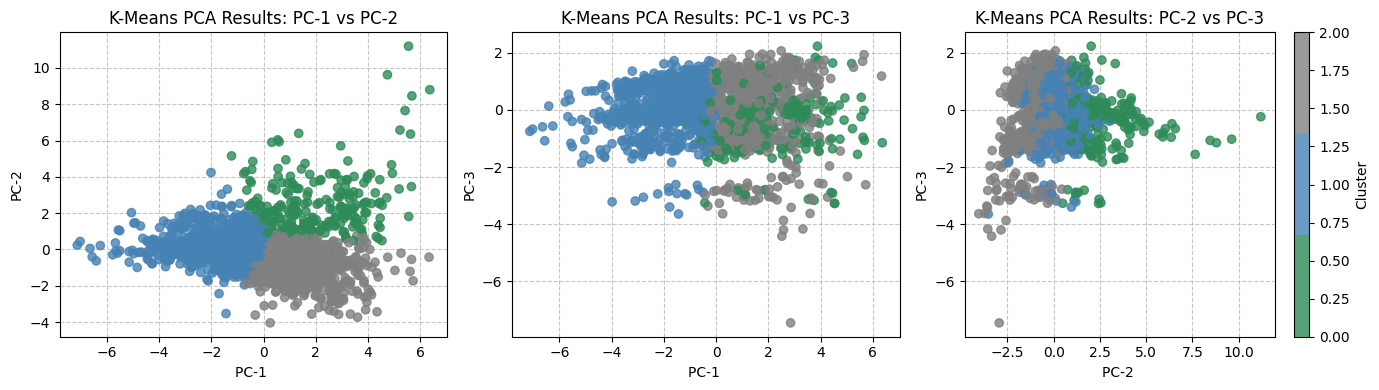

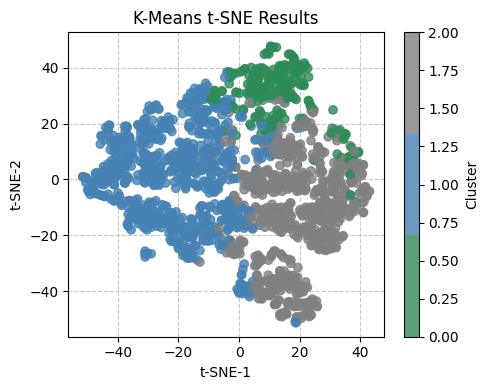

In [9]:
# Perform PCA
pca = PCA(n_components = optimal_components)
movies_pca = pca.fit_transform(numerical_movies_scaled)

# Perform t-SNE
tsne = TSNE(n_components = 2)
movies_tsne = tsne.fit_transform(numerical_movies_scaled)

# Visualize the clusters in PCA and t-SNE plots
color_vector = movies_df["KMeans_Cluster"]
plot_2D(reduced_data1 = movies_pca, plot1 = "PCA", method1 = "K-Means", 
        reduced_data2 = movies_tsne, plot2 = "TSNE", method2 = "K-Means", 
        color_vector = color_vector)


From this overview, the follows predictions could be made:

- **Cluster 0 (Green):** Movies with **high ratings** and **financial performance/budget**. These movies likely consist of massive blockbusters that met or exceeded expectations in both critical acclaim and revenue. 

- **Cluster 1 (Blue):** Movies with **average financial performance/budget** but **lower ratings**. These movies may consist of big budget productions that underwhelmed both critics and audiences, resulting in mixed or limited success.

- **Cluster 2 (Gray):** Movies with **high ratings** but a **poor financial performance**. Movies in this cluster could consist of critically acclaimed films, such as indie movies, that resonated with audiences but struggled at the box office.

All 3 clusters have a relatively even age rating distribution. *Clusters 0 and 2 are where the oscar-winning movies would likely reside.*

### Feature Importance for K-Means Clusters:

#### Cluster 0 (Green)

The details of Cluster 0 (Green) support the conclusions. Cluster 0 has the following average values:

- **Rating:** 7.05       
  - Rank 2 of 3

- **Budget:** $165,165,700   
  - Rank 1 of 3

- **Revenue:** $711,345,700  
  - Rank 1 of 3

- **Oscar Wins:** 0.48       
  - Rank 2 of 3

- **Popularity:** 89.25    
  - Rank 1 of 3

In [10]:
# Cluster 0

movies_df[movies_df["KMeans_Cluster"] == 0].describe()

,Year,Runtime,Metascore_Rating,IMDB_Rating,Rotten_Tomatoes_Rating,TMDB_Rating,Average_Rating,Oscar_Wins,Oscar_Nominations,Budget,Budget_Normalized,Revenue,Revenue_Normalized,Return_On_Investment,Popularity,KMeans_Cluster
count,231.000000,231.000000,231.000000,231.000000,231.00000,231.000000,231.000000,231.000000,231.000000,2.310000e+02,231.000000,2.310000e+02,231.000000,231.000000,231.000000,231.0
mean,2013.567100,128.545455,6.522944,7.157576,7.38961,7.149784,7.054978,0.484848,0.541126,1.651657e+08,1.746080,7.113457e+08,1.824353,4.869566,89.253177,0.0
std,6.523773,23.650836,1.278804,0.708533,1.74480,0.568665,0.976953,1.314959,1.185711,6.702415e+07,1.124273,4.087754e+08,1.530868,3.124088,74.270062,0.0
min,1992.000000,85.000000,3.200000,5.600000,1.80000,5.800000,4.125000,0.000000,0.000000,1.800000e+07,-0.722497,1.419400e+08,-0.308078,0.709700,3.085000,0.0
25%,2010.000000,112.000000,5.600000,6.600000,6.30000,6.700000,6.375000,0.000000,0.000000,1.250000e+08,1.072336,4.293743e+08,0.768367,2.820661,46.613000,0.0
50%,2014.000000,128.000000,6.400000,7.100000,7.60000,7.200000,7.100000,0.000000,0.000000,1.600000e+08,1.659431,6.320918e+08,1.527546,4.084414,67.545000,0.0
75%,2018.000000,143.000000,7.500000,7.700000,8.80000,7.600000,7.850000,0.000000,1.000000,2.000000e+08,2.330396,8.696873e+08,2.417343,5.877355,102.450500,0.0
max,2024.000000,206.000000,9.600000,9.000000,9.90000,8.500000,8.875000,11.000000,10.000000,4.600000e+08,6.691673,2.923706e+09,10.109666,19.944158,743.706000,0.0


#### Cluster 1 (Blue)

The details of Cluster 1 (Blue) support the conclusions. Cluster 1 has the following average values:

- **Rating:** 4.95           
  - Rank 3 of 3   
  
- **Budget:** $56,847,490    
  - Rank 2 of 3   

- **Revenue:** $154,359,200  
  - Rank 2 of 3  

- **Oscar Wins:** 0.01      
  - Rank 3 of 3  

- **Popularity:** 29.19     
  - Rank 3 of 3

In [11]:
movies_df[movies_df["KMeans_Cluster"] == 1].describe()

,Year,Runtime,Metascore_Rating,IMDB_Rating,Rotten_Tomatoes_Rating,TMDB_Rating,Average_Rating,Oscar_Wins,Oscar_Nominations,Budget,Budget_Normalized,Revenue,Revenue_Normalized,Return_On_Investment,Popularity,KMeans_Cluster
count,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,7.940000e+02,794.000000,7.940000e+02,794.000000,794.000000,794.000000,794.0
mean,2006.824937,107.130982,4.273804,5.880479,3.534761,6.126952,4.953999,0.013854,0.078086,5.684749e+07,-0.070864,1.543592e+08,-0.261568,5.094116,29.197655,1.0
std,9.470780,15.285281,1.027648,0.737389,1.724726,0.559593,0.839499,0.127284,0.390878,4.234280e+07,0.710264,1.230307e+08,0.460751,21.950218,17.752629,0.0
min,1929.000000,75.000000,0.900000,1.600000,0.000000,3.100000,1.975000,0.000000,0.000000,1.000000e+05,-1.022755,2.007100e+06,-0.832128,0.053964,0.506000,1.0
25%,2002.000000,96.000000,3.600000,5.500000,2.100000,5.800000,4.375000,0.000000,0.000000,2.500000e+07,-0.605078,7.167848e+07,-0.571208,1.734301,17.269750,1.0
50%,2008.000000,105.000000,4.350000,6.000000,3.500000,6.200000,5.075000,0.000000,0.000000,4.800000e+07,-0.219273,1.198212e+08,-0.390913,2.729589,25.511500,1.0
75%,2013.000000,117.000000,5.000000,6.400000,4.800000,6.500000,5.593750,0.000000,0.000000,8.000000e+07,0.317499,2.045441e+08,-0.073625,4.277366,36.317750,1.0
max,2023.000000,219.000000,6.900000,7.600000,8.200000,8.300000,6.650000,2.000000,4.000000,2.170000e+08,2.615557,8.772448e+08,2.445646,429.644100,143.265000,1.0


#### Cluster 2 (Gray)

The details of Cluster 2 (Gray) support the conclusions. Cluster 2 has the following average values:

- **Rating:** 7.10          
  - Rank 2 of 3

- **Budget:** $35,447,120    
  - Rank 3 of 3

- **Revenue:** $151,853,500  
  - Rank 3 of 3

- **Oscar Wins:** 0.51       
  - Rank 1 of 3

- **Popularity:** 32.47      
  - Rank 2 of 3

In [12]:
movies_df[movies_df["KMeans_Cluster"] == 2].describe()

,Year,Runtime,Metascore_Rating,IMDB_Rating,Rotten_Tomatoes_Rating,TMDB_Rating,Average_Rating,Oscar_Wins,Oscar_Nominations,Budget,Budget_Normalized,Revenue,Revenue_Normalized,Return_On_Investment,Popularity,KMeans_Cluster
count,674.00000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,6.740000e+02,674.000000,6.740000e+02,674.000000,6.740000e+02,674.000000,674.0
mean,1998.04451,117.982196,6.918398,7.239021,8.023887,7.102967,7.321068,0.575668,0.514837,3.544712e+07,-0.429837,1.515835e+08,-0.271963,3.655814e+03,32.474991,2.0
std,16.55486,22.525066,1.142266,0.566032,1.210667,0.526383,0.698422,1.459020,1.155356,3.010978e+07,0.505066,1.233017e+08,0.461766,9.463045e+04,23.048295,0.0
min,1927.00000,69.000000,3.800000,5.700000,3.800000,5.500000,5.775000,0.000000,0.000000,5.000000e+00,-1.024432,2.133452e+06,-0.831655,1.125000e-01,1.502000,2.0
25%,1989.00000,102.250000,6.100000,6.800000,7.300000,6.700000,6.775000,0.000000,0.000000,1.200000e+07,-0.823142,6.032500e+07,-0.613727,2.316924e+00,16.296000,2.0
50%,2001.00000,116.000000,6.800000,7.200000,8.300000,7.100000,7.275000,0.000000,0.000000,2.700000e+07,-0.571530,1.236147e+08,-0.376706,4.264167e+00,26.758500,2.0
75%,2011.00000,128.000000,7.600000,7.600000,9.000000,7.475000,7.825000,0.000000,1.000000,5.112500e+07,-0.166854,2.138716e+08,-0.038693,7.889231e+00,42.570000,2.0
max,2023.00000,238.000000,10.000000,9.200000,10.000000,8.700000,9.400000,11.000000,10.000000,1.700000e+08,1.827172,7.753980e+08,2.064229,2.456760e+06,190.434000,2.0


I then filtered the updated dataset by only retaining oscar-winning movies. By doing this, I could confirm how well the K-Means clustering method performed very well in identifying movies that have achieved critical success. **72%** (156/216) of all Oscar-winning movies reside in cluster 2. However, upon examining cluster 2 further, only **23%**(156/674) of movies in the cluster were  Oscar-winning movies. Movies with Oscar nominations follow the same trend. **61%** (179/288) of all Oscar nominated movies appear in cluster 2, but only **26%** of movies in cluster 2 have a nomination.

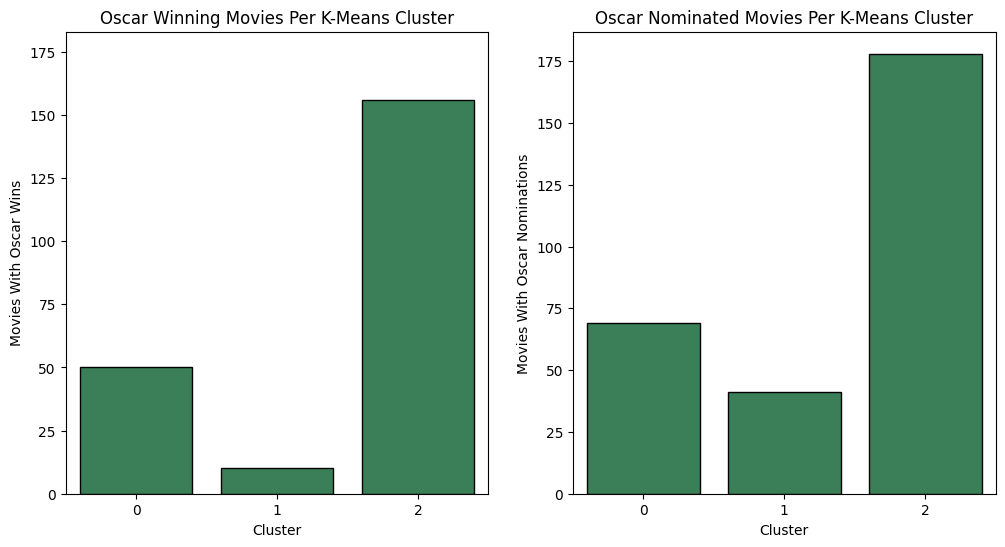

In [13]:
oscar_movies_df = movies_df[movies_df["Won_Award"] == True]
movies_df["Nominated"] = movies_df["Oscar_Nominations"] != 0
oscar_nom_movies_df = movies_df[movies_df["Nominated"] == True]

max_count = max(
    oscar_movies_df["KMeans_Cluster"].value_counts().max(),
    oscar_nom_movies_df["KMeans_Cluster"].value_counts().max()
) + 5


fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.countplot(data = oscar_movies_df, x = "KMeans_Cluster", color = "seagreen", edgecolor = "black", ax = axes[0])
axes[0].set_title("Oscar Winning Movies Per K-Means Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Movies With Oscar Wins")
axes[0].set_ylim(0, max_count)

sns.countplot(data = oscar_nom_movies_df, x = "KMeans_Cluster", color = "seagreen", edgecolor = "black", ax = axes[1])
axes[1].set_title("Oscar Nominated Movies Per K-Means Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Movies With Oscar Nominations")
axes[0].set_ylim(0, max_count)

plt.tight_layout
plt.show()

In addition, this clustering method did not perform well when attempting to classify movies by genre. Apart from cluster 0 (Green), which does not contain many movies in half of the available genres, there was a somewhat even distribution of genres among the clusters.

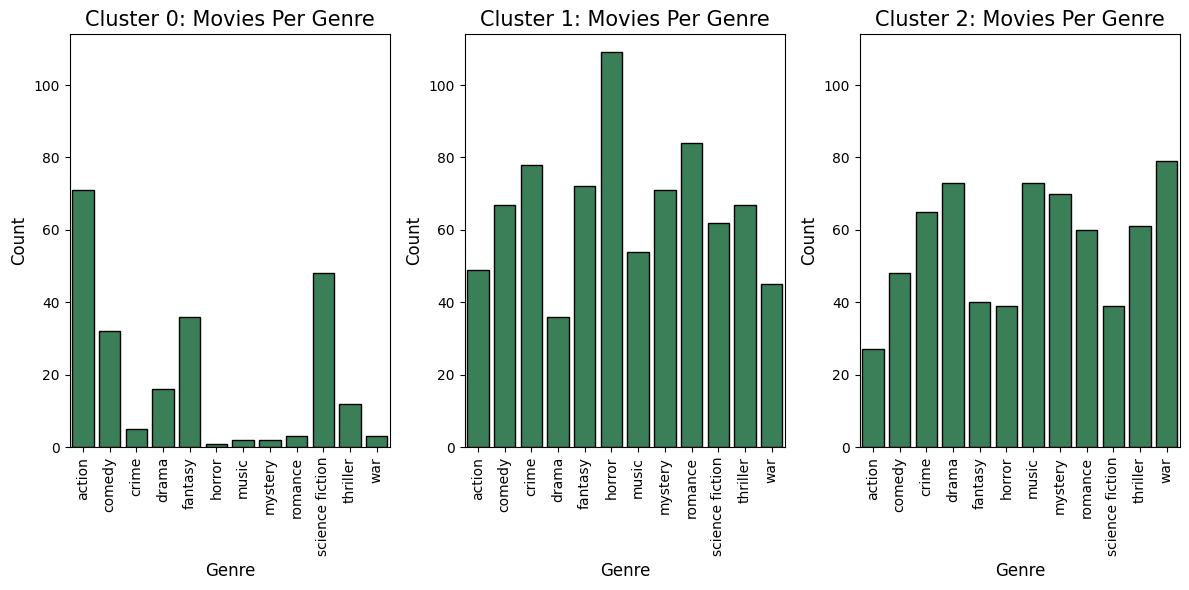

In [14]:
#Generate plots for number of movies per genre per cluster
cluster_0_movies = movies_df[movies_df["KMeans_Cluster"] == 0].sort_values("Genre")
cluster_1_movies = movies_df[movies_df["KMeans_Cluster"] == 1].sort_values("Genre")
cluster_2_movies = movies_df[movies_df["KMeans_Cluster"] == 2].sort_values("Genre")
cluster_3_movies = movies_df[movies_df["KMeans_Cluster"] == 3].sort_values("Genre")
cluster_4_movies = movies_df[movies_df["KMeans_Cluster"] == 4].sort_values("Genre")


max_count = max(
    cluster_0_movies["Genre"].value_counts().max(),
    cluster_1_movies["Genre"].value_counts().max(),
    cluster_2_movies["Genre"].value_counts().max(),
    cluster_3_movies["Genre"].value_counts().max(),
    cluster_4_movies["Genre"].value_counts().max()
) + 5

fig, axes = plt.subplots(1, 3, figsize = (12, 6))


sns.countplot(data = cluster_0_movies, x = "Genre", color = "seagreen", edgecolor = "black", ax = axes[0])
axes[0].set_title("Cluster 0: Movies Per Genre", fontsize = 15)
axes[0].set_xlabel("Genre", fontsize = 12)
axes[0].set_ylabel("Count", fontsize = 12)
axes[0].tick_params(axis = "x", rotation = 90)
axes[0].set_ylim(0, max_count)

sns.countplot(data = cluster_1_movies, x = "Genre", color = "seagreen", edgecolor = "black", ax = axes[1])
axes[1].set_title("Cluster 1: Movies Per Genre", fontsize = 15)
axes[1].set_xlabel("Genre", fontsize = 12)
axes[1].set_ylabel("Count", fontsize = 12)
axes[1].tick_params(axis = "x", rotation = 90)
axes[1].set_ylim(0, max_count)

sns.countplot(data = cluster_2_movies, x = "Genre", color = "seagreen", edgecolor = "black", ax = axes[2])
axes[2].set_title("Cluster 2: Movies Per Genre", fontsize = 15)
axes[2].set_xlabel("Genre", fontsize = 12)
axes[2].set_ylabel("Count", fontsize = 12)
axes[2].tick_params(axis = "x", rotation = 90)
axes[2].set_ylim(0, max_count)

plt.tight_layout()
plt.show()

### DBSCAN



The plot below displays silhouette scores for each parameter solution. For DBSCAN, the number of parameters is divided by 4 to determine epsilon values, which defines the radius of a neighborhood around a data point. Using the silhouette score method, the optimal number of parameters using DBSCAN was 20. 

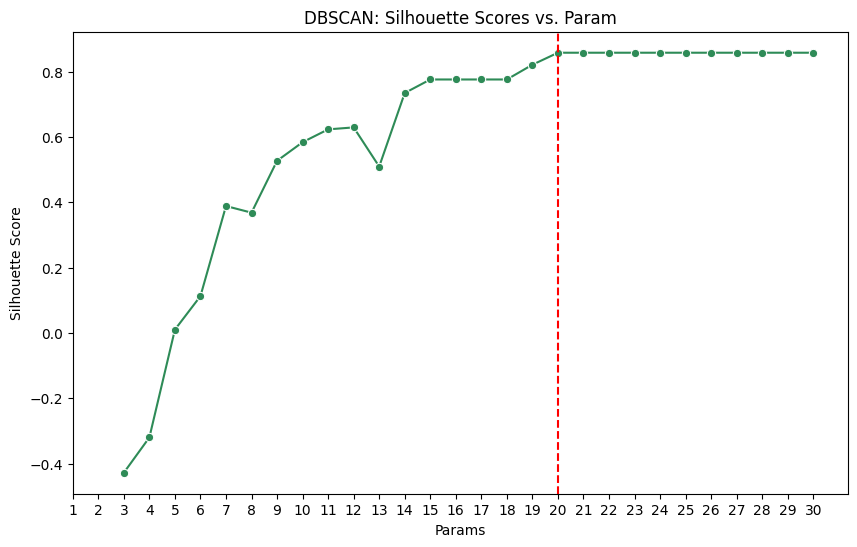

Optimal Param: 20
 Optimal Score: 0.8575704199843973


In [15]:
# DBSCAN Clustering Method

# Empty lists to store parameters and silhouette scores
params = []
silhouette_scores = []

# Track the highest silhouette score and associated parameter with opt_param and opt_labels
optimal_param = 0
optimal_score = 0
optimal_labels = None

param_testing_max = 31


for param in range(2, param_testing_max):
    eps = param * 0.25
    model = DBSCAN(eps = eps)

    # Fit model to numerical_movies_scaled and retrieve labels
    labels = model.fit_predict(numerical_movies_scaled)

    # Track the highest silhouette score and associated parameter with `optimal_params` and optimal_score = 0
    if len(set(labels)) > 1:
        score = silhouette_score(numerical_movies_scaled, labels)

        # Append the silhouette score for each param to silhouette_scores list
        silhouette_scores.append(score)
        params.append(param)

        # Track the highest silhouette score and associated parameter
        if score > optimal_score:
            optimal_score = score
            optimal_param = param
            optimal_labels = labels
    else:
        silhouette_scores.append(None)
        params.append(param)

# Visualize Silhouette Scores
plt.figure(figsize = (10, 6))
sns.lineplot(x = params, y = silhouette_scores, marker = "o", color = "seagreen")
plt.title("DBSCAN: Silhouette Scores vs. Param")
plt.xlabel("Params")
plt.ylabel("Silhouette Score")
plt.xticks(range(1, param_testing_max))
plt.axvline(x = optimal_param, color = "red", linestyle = "--", label = f"Optimal Param = {optimal_param}")
plt.show()

print(f"Optimal Param: {optimal_param}\n",
      f"Optimal Score: {optimal_score}")

movies_df["DBSCAN_Cluster"] = optimal_labels

To visualize the result of DBSCAN method, PCA and t-SNE plots were generated below using the newly calculated DBSCAN clusters. Both the PCA and t-SNE plots displays 2 clusters as a result of DBSCAN. Unfortunately, 1 genuine cluster and 1 noise cluster was created, signifying that DBSCAN is not an effective clustering method for this dataset. As a result, it will not used to interpret what factors influence success in the film industry.

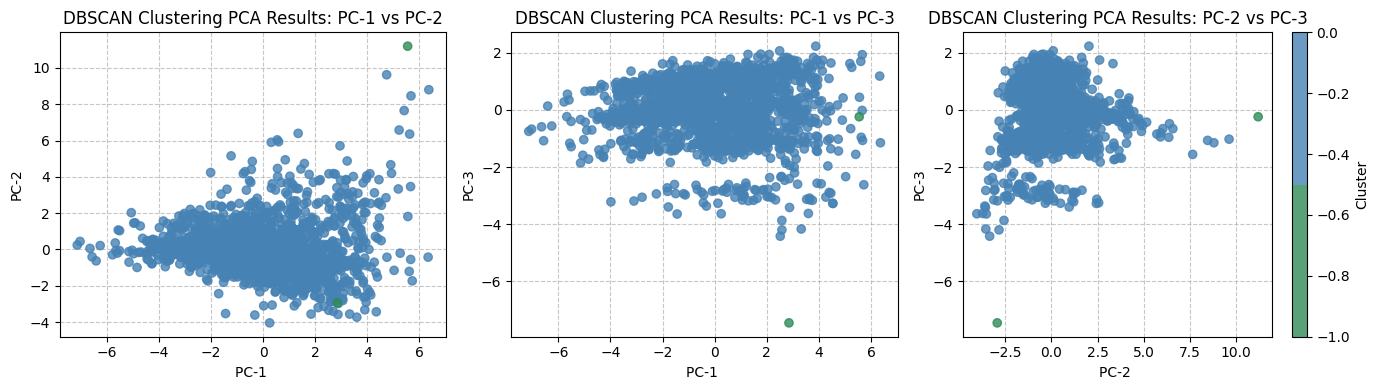

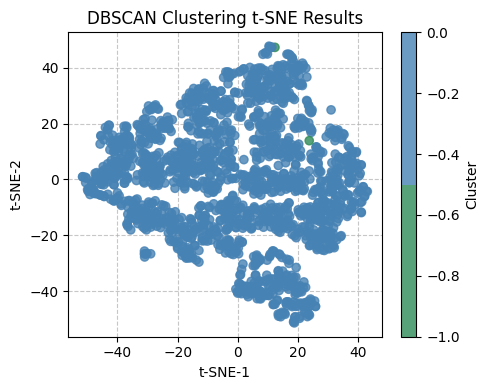

In [16]:
# Perform PCA
pca = PCA(n_components = optimal_components)
movies_pca = pca.fit_transform(numerical_movies_scaled)

# Perform t-SNE
tsne = TSNE(n_components = 2)
movies_tsne = tsne.fit_transform(numerical_movies_scaled)

# Visualize the clusters in PCA and t-SNE plots
color_vector = movies_df["DBSCAN_Cluster"]
plot_2D(reduced_data1 = movies_pca, plot1 = "PCA", method1 = "DBSCAN Clustering", 
        reduced_data2 = movies_tsne, plot2 = "TSNE", method2 = "DBSCAN Clustering", 
        color_vector = color_vector)

### Hierarchical Clustering



The plot below displays silhouette scores for each clustering solution. Using the silhouette score method, the optimal number of clusters using Hierarchichal clustering was also 3. As a result, the data will be split into 3 groupings using Hierarchial clustering. 

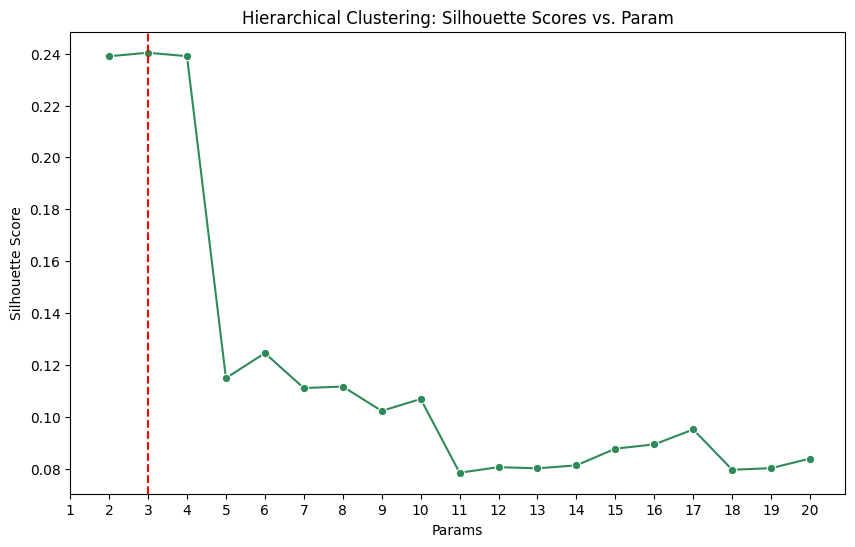

Optimal Cluster Count: 3
 Optimal Score: 0.24036088920926807


In [17]:
# Hierarchical Clustering Method

# Empty lists to store clusters and silhouette scores
clusters = []
silhouette_scores = []

# Track the highest silhouette score and associated cluster with optimal_cluster and optimal_labels
optimal_clusters = 0
optimal_score = 0
optimal_labels = None

cluster_testing_max = 21


for cluster in range(2, cluster_testing_max):
    model = AgglomerativeClustering(n_clusters = cluster)

    # Fit model to numerical_movies_scaled and retrieve labels
    labels = model.fit_predict(numerical_movies_scaled)

    # Track the highest silhouette score and associated cluster with optimal_clusters and optimal_score = 0
    if len(set(labels)) > 1:
        score = silhouette_score(numerical_movies_scaled, labels)

        # Append the silhouette score for each param to silhouette_scores list
        silhouette_scores.append(score)
        clusters.append(cluster)

        # Track the highest silhouette score and associated cluster
        if score > optimal_score:
            optimal_score = score
            optimal_clusters = cluster
            optimal_labels = labels
    else:
        silhouette_scores.append(None)
        clusters.append(cluster)


# Visualize Silhouette Scores
plt.figure(figsize = (10, 6))
sns.lineplot(x = clusters, y = silhouette_scores, marker = "o", color = "seagreen")
plt.title("Hierarchical Clustering: Silhouette Scores vs. Param")
plt.xlabel("Params")
plt.ylabel("Silhouette Score")
plt.xticks(range(1, cluster_testing_max))
plt.axvline(x = optimal_clusters, color = "red", linestyle = "--", label = f"Optimal Param = {optimal_clusters}")
plt.show()

print(f"Optimal Cluster Count: {optimal_clusters}\n",
      f"Optimal Score: {optimal_score}")

movies_df["Hierarchical_Cluster"] = optimal_labels

To visualize the result of Hierarchichal clustering, PCA and t-SNE plots were generated below using the newly calculated Hierarchical cluster values. In the PCA and t-SNE plots below, the 3 Hierarchichal clusters are displayed. The PCA plot shows 2 distinct groupings on either side of the central mass. These cluster is primary separate movies by their ratings. Movies with higher ratings fall into cluster 0 (Green) and movies with lower ratings fall in to cluster 1 (Blue). Cluster 3 (Gray) consisted of only one data point, which turned out to be the movie "the beatles eight days a week". For the t-SNE plot, the clustering is more spread out.

To recap, below is a sumary of what each principal component represents.

- **PC-1:** Differentiates movies based on ratings across platforms. Movies with high ratings cluster together (Quality)
  
- **PC-2:** Captures how movies perform financially and in terms of an audience's reaction (Financial Success & Popularity)
  
- **PC-3:** Separates movies based on age rating (Audience Maturity)

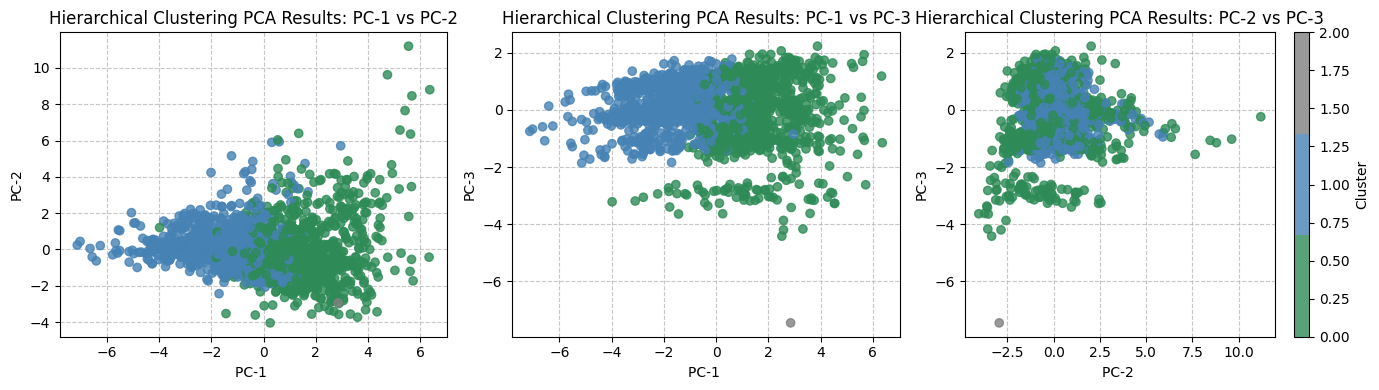

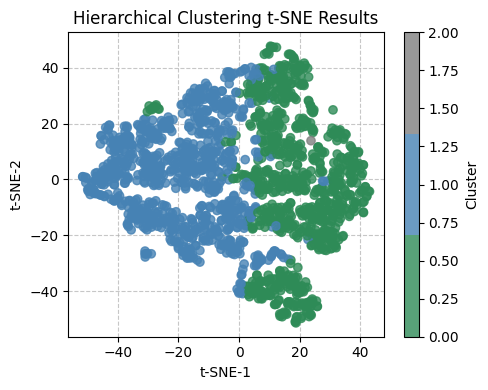

In [18]:
# Perform PCA
pca = PCA(n_components = optimal_components)
movies_pca = pca.fit_transform(numerical_movies_scaled)

# Perform t-SNE
tsne = TSNE(n_components = 2)
movies_tsne = tsne.fit_transform(numerical_movies_scaled)

# Visualize the clusters in PCA and t-SNE plots
color_vector = movies_df["Hierarchical_Cluster"]
plot_2D(reduced_data1 = movies_pca, plot1 = "PCA", method1 = "Hierarchical Clustering", 
        reduced_data2 = movies_tsne, plot2 = "TSNE", method2 = "Hierarchical Clustering", 
        color_vector = color_vector)

From this overview, the follows predictions could be made:

- **Cluster 0 (Green):** Movies with **high ratings** and **financial performance/budget**. These movies likely consist of massive blockbusters that met or exceeded expectations in both critical acclaim and revenue. 

- **Cluster 1 (Blue):** Movies with **lower ratings** and an **average financial performance/budget**. These movies may consist of big budget productions that underwhelmed both critics and audiences, resulting in mixed or limited success.

- **Cluster 2 (Gray):** The single movie (the beatles eight days a week) has **high ratings**, **low financial performance**, and is has an **extremely low age rating**.

Similar to K-Means, both clusters have a relatively even age rating distribution.

### Feature Importance for Hierarchical Clusters:

#### Cluster 0 (Green)

The details of Cluster 0 (Green) supports the conclusions. Cluster 0 has the following average values:

- **Rating:** 7.3          
  - Rank 1 of 2

- **Budget:** $63,708,3200  
  - Rank 1 of 2

- **Revenue:** $285,239,900
  - Rank 1 of 2

- **Oscar Wins:** 0.59       
  - Rank 1 of 2

- **Popularity:** 47.36 
  - Rank 1 of 2

In [19]:
movies_df[movies_df["Hierarchical_Cluster"] == 0].describe()

,Year,Runtime,Metascore_Rating,IMDB_Rating,Rotten_Tomatoes_Rating,TMDB_Rating,Average_Rating,Oscar_Wins,Oscar_Nominations,Budget,Budget_Normalized,Revenue,Revenue_Normalized,Return_On_Investment,Popularity,KMeans_Cluster,DBSCAN_Cluster,Hierarchical_Cluster
count,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,8.280000e+02,828.000000,8.280000e+02,828.000000,828.000000,828.000000,828.000000,828.000000,828.0
mean,2001.920290,119.708937,6.893116,7.235266,7.949517,7.139734,7.304408,0.596618,0.508454,6.370832e+07,0.044220,2.852399e+08,0.228582,9.622340,47.360825,1.486715,-0.001208,0.0
std,16.726867,23.936354,1.207870,0.651471,1.391193,0.555551,0.809967,1.477469,1.177654,6.393468e+07,1.072449,3.345595e+08,1.252929,32.475952,50.673040,0.840951,0.034752,0.0
min,1927.000000,69.000000,2.400000,4.400000,1.000000,5.200000,3.375000,0.000000,0.000000,1.150000e+05,-1.022503,2.133452e+06,-0.831655,0.112500,1.778000,0.000000,-1.000000,0.0
25%,1993.750000,102.000000,6.100000,6.800000,7.200000,6.700000,6.775000,0.000000,0.000000,1.500000e+07,-0.772820,8.249218e+07,-0.530711,2.580428,19.622000,1.000000,0.000000,0.0
50%,2006.000000,116.000000,6.800000,7.300000,8.300000,7.100000,7.325000,0.000000,0.000000,4.000000e+07,-0.353466,1.691638e+08,-0.206124,4.287481,33.293500,2.000000,0.000000,0.0
75%,2015.000000,132.000000,7.700000,7.700000,9.000000,7.500000,7.875000,0.000000,1.000000,9.000000e+07,0.485241,3.680353e+08,0.538651,7.341326,55.281000,2.000000,0.000000,0.0
max,2024.000000,238.000000,10.000000,9.200000,10.000000,8.700000,9.400000,11.000000,10.000000,4.600000e+08,6.691673,2.923706e+09,10.109666,556.765380,743.706000,2.000000,0.000000,0.0


#### Cluster 1 (Blue)

The details of Cluster 1 (Blue) support? the conclusions. Cluster 1 has the following average values:

- **Rating:** 5.1        
  - Rank 2 of 2

- **Budget:** $62,564,420
  - Rank 2 of 2

- **Revenue:** $175,699,400
  - Rank 2 of 2

- **Oscar Wins:** 0.02
  - Rank 2 of 2

- **Popularity:** 30.41
  - Rank 2 of 2

In [20]:
movies_df[movies_df["Hierarchical_Cluster"] == 1].describe()

,Year,Runtime,Metascore_Rating,IMDB_Rating,Rotten_Tomatoes_Rating,TMDB_Rating,Average_Rating,Oscar_Wins,Oscar_Nominations,Budget,Budget_Normalized,Revenue,Revenue_Normalized,Return_On_Investment,Popularity,KMeans_Cluster,DBSCAN_Cluster,Hierarchical_Cluster
count,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,870.000000,8.700000e+02,870.000000,8.700000e+02,870.000000,870.000000,870.000000,870.000000,870.0,870.0
mean,2006.470115,109.254023,4.423563,5.980460,3.827471,6.189080,5.105144,0.019540,0.129885,6.256442e+07,0.025032,1.756994e+08,-0.181648,5.127847,30.414302,1.044828,0.0,1.0
std,9.372039,16.337383,1.103789,0.758434,1.922280,0.570493,0.933052,0.154219,0.501233,5.504442e+07,0.923323,1.701917e+08,0.637370,21.136869,19.137611,0.373537,0.0,0.0
min,1961.000000,73.000000,0.900000,1.600000,0.000000,3.100000,1.975000,0.000000,0.000000,1.000000e+05,-1.022755,2.007100e+06,-0.832128,0.053964,0.506000,0.000000,0.0,1.0
25%,2001.000000,97.000000,3.700000,5.600000,2.300000,5.900000,4.450000,0.000000,0.000000,2.500000e+07,-0.605078,7.200719e+07,-0.569977,1.750602,17.317250,1.000000,0.0,1.0
50%,2008.000000,107.000000,4.500000,6.100000,3.800000,6.200000,5.200000,0.000000,0.000000,4.950000e+07,-0.194112,1.258148e+08,-0.368467,2.755704,25.957000,1.000000,0.0,1.0
75%,2013.000000,119.000000,5.200000,6.500000,5.175000,6.500000,5.800000,0.000000,0.000000,8.150000e+07,0.342661,2.186088e+08,-0.020952,4.289324,38.816000,1.000000,0.0,1.0
max,2023.000000,219.000000,7.400000,7.600000,9.300000,8.300000,7.350000,2.000000,4.000000,4.160000e+08,5.953611,1.405404e+09,4.423607,429.644100,143.265000,2.000000,0.0,1.0


I then filtered the updated dataset by only retaining oscar-winning movies. The Hierarchical clustering method performed better than K-Means in identifying movies that have achieved critical success, **but** that is only due to the method generating 2 usable, much larger, clusters. With this clustering method, movies that win or get nominated for Oscars for the most part are rated highly. Cluster 0 contains **93%** (206/216) of all oscar-winning movies, but only **24%** (206/828) movies wihtin the cluster have won an Oscar. 

There is a similar case for Oscar nominations. Cluster 0 contains **75%** (217/288) of all oscar-winning movies, but only **26%** (217/828) movies within the cluster have won an Oscar. 

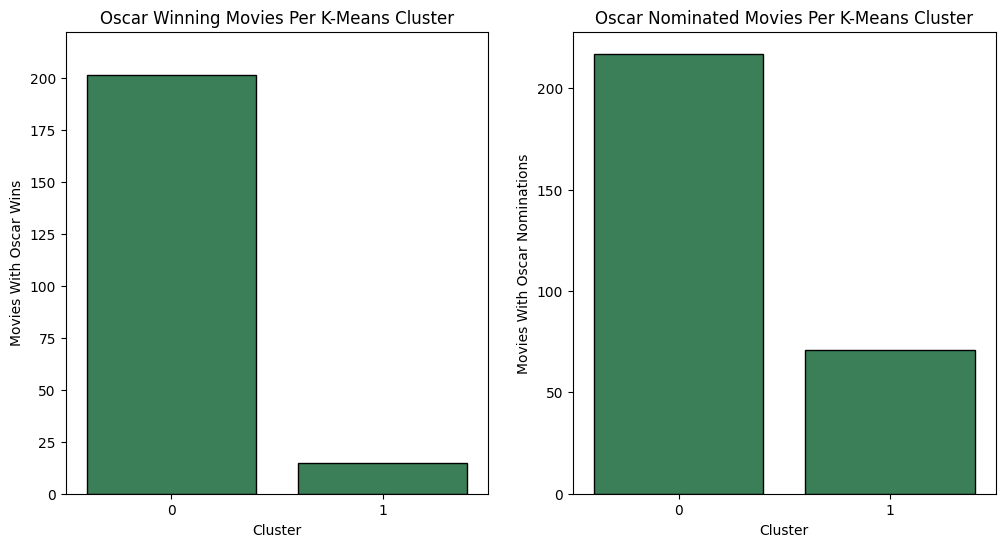

In [21]:
# Create plots for number of movies with oscar wins and nominations per cluster
oscar_movies_df = movies_df[movies_df["Won_Award"] == True]
movies_df["Nominated"] = movies_df["Oscar_Nominations"] != 0
oscar_nom_movies_df = movies_df[movies_df["Nominated"] == True]

max_count = max(
    oscar_movies_df["Hierarchical_Cluster"].value_counts().max(),
    oscar_nom_movies_df["Hierarchical_Cluster"].value_counts().max()
) + 5


fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.countplot(data = oscar_movies_df, x = "Hierarchical_Cluster", color = "seagreen", edgecolor = "black", ax = axes[0])
axes[0].set_title("Oscar Winning Movies Per K-Means Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Movies With Oscar Wins")
axes[0].set_ylim(0, max_count)

sns.countplot(data = oscar_nom_movies_df, x = "Hierarchical_Cluster", color = "seagreen", edgecolor = "black", ax = axes[1])
axes[1].set_title("Oscar Nominated Movies Per K-Means Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Movies With Oscar Nominations")
axes[0].set_ylim(0, max_count)

plt.tight_layout
plt.show()

Additionally, this clustering method does not perform well when attempting to classify movies by genre. Both signfiicant clusters have a semi-distributed spread across all genres.

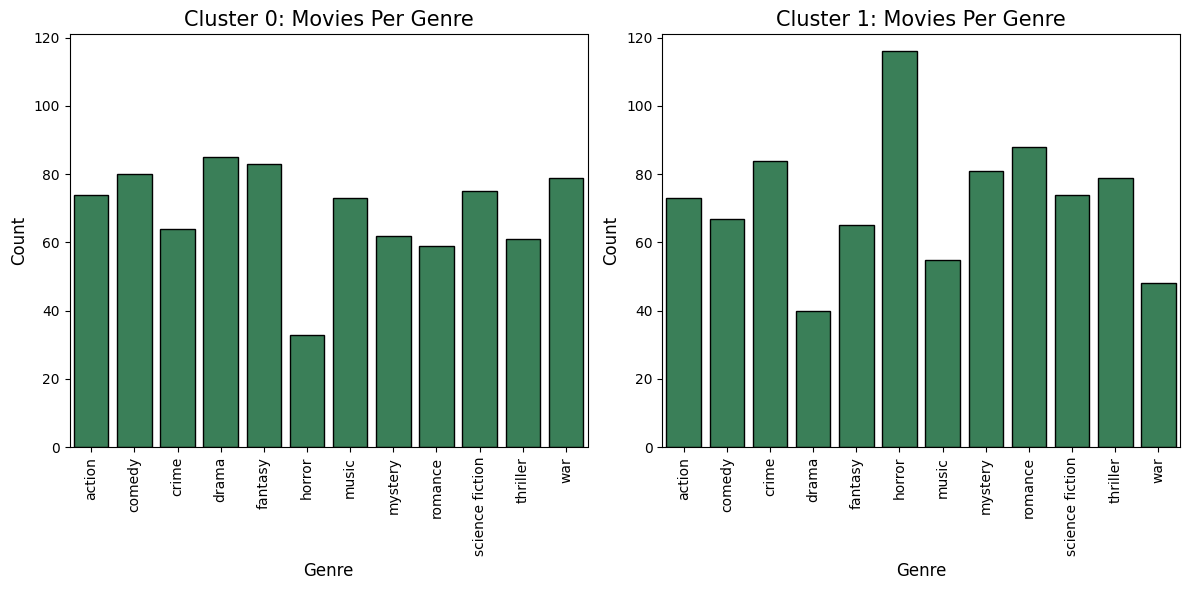

In [22]:
# Create plots to visualize count of movies per genre per cluster
cluster_0_movies = movies_df[movies_df["Hierarchical_Cluster"] == 0].sort_values("Genre")
cluster_1_movies = movies_df[movies_df["Hierarchical_Cluster"] == 1].sort_values("Genre")


max_count = max(
    cluster_0_movies["Genre"].value_counts().max(),
    cluster_1_movies["Genre"].value_counts().max()
) + 5

fig, axes = plt.subplots(1, 2, figsize = (12, 6))


sns.countplot(data = cluster_0_movies, x = "Genre", color = "seagreen", edgecolor = "black", ax = axes[0])
axes[0].set_title("Cluster 0: Movies Per Genre", fontsize = 15)
axes[0].set_xlabel("Genre", fontsize = 12)
axes[0].set_ylabel("Count", fontsize = 12)
axes[0].tick_params(axis = "x", rotation = 90)
axes[0].set_ylim(0, max_count)

sns.countplot(data = cluster_1_movies, x = "Genre", color = "seagreen", edgecolor = "black", ax = axes[1])
axes[1].set_title("Cluster 1: Movies Per Genre", fontsize = 15)
axes[1].set_xlabel("Genre", fontsize = 12)
axes[1].set_ylabel("Count", fontsize = 12)
axes[1].tick_params(axis = "x", rotation = 90)
axes[1].set_ylim(0, max_count)

plt.tight_layout()
plt.show()


{{< include closing.qmd >}} 